## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-04 10:41:14--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: 'CreditScoring.csv.10'

     0K .......... .......... .......... .......... .......... 28% 1.23M 0s
    50K .......... .......... .......... .......... .......... 56% 38.2M 0s
   100K .......... .......... .......... .......... .......... 84% 91.3M 0s
   150K .......... .......... ........                        100%  130M=0.04s

2021-10-04 10:41:21 (4.17 MB/s) - 'CreditScoring.csv.10' saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
# look at the all columns
df.columns
# look at the data types first:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int32
dtype: object

In [9]:
# then numerical ones are: 'seniority', 'time', 'income', 'debt', 'assets', and rest of them are categorical
categorical = ['home', 'marital', 'records', 'job']
numerical = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount','price', 'default' ]

# another way of selecting all categorical and numerical variables from a dataset
#categorical = list(df.select_dtypes ('object'))
#categorical

#numerical = list(df.select_dtypes ('int64'))
#numerical

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [10]:
# load all libraries

df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# default_payment is the target variable
y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

# delete the target variable
#del df_train['default']
#del df_val['default']
#del df_test['default']


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [11]:
# auc for all numerical variables

from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

for n in numerical:
    fpr, tpr, thresholds = roc_curve(y_train, df_train[n].values)
    auc_score= auc(fpr, tpr)
    #print(n,auc_score )
    
    if auc_score < 0.5:
        fpr, tpr, thresholds = roc_curve(y_train, -df_train[n].values)
        auc_score= auc(fpr, tpr)
        print(n,auc_score )        

seniority 0.7093778624491943
age 0.5732933272499939
expenses 0.5009184217217011
income 0.682006666132633
assets 0.6486042567122802
debt 0.5047829675783548


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

# Answer 1: seniority has the highest AUC

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [12]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']

# first logistic regression
dv = DictVectorizer(sparse=False)

train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
default_decision = (y_pred >= 0.5)
(y_val == default_decision).mean()

accuracy = (y_val == default_decision).mean()
accuracy

0.7800224466891134

In [13]:
# auc of the model above
auc_model = roc_auc_score(y_val, y_pred)
auc_model.round(3)

0.812

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

# Answer 2: The AUC of the model is 0.812 

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [14]:
thresholds = np.linspace(0, 1, 101)
scores =[]

for t in thresholds:
    actual_positive = (y_val == 1) # we need our confusion matrix here for all thresholds
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp/(tp+fp) #precision
    r = tp/(tp+fn) #recall
    
    scores.append((t,p,r))


C:\Users\kaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [15]:
# put them into a dataframe:
columns = ['threshold','precision', 'recall']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores

,threshold,precision,recall
0,0.00,0.276094,1.000000
1,0.01,0.279228,1.000000
2,0.02,0.284714,0.991870
3,0.03,0.289820,0.983740
4,0.04,0.300621,0.983740
5,0.05,0.304071,0.971545
6,0.06,0.312418,0.971545
7,0.07,0.320323,0.967480
8,0.08,0.329640,0.967480
9,0.09,0.339056,0.963415


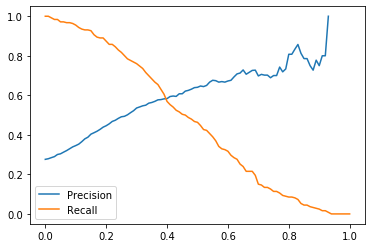

In [16]:
# let's plot them:
plt.plot(df_scores.threshold, df_scores['precision'], label ='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label = 'Recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

# Answer 3: The precision and recall curves meet at threshold 0.4

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [17]:
thresholds = np.linspace(0, 1, 101)
scores =[]

for t in thresholds:
    actual_positive = (y_val == 1) # we need our confusion matrix here for all thresholds
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp/(tp+fp) #precision
    r = tp/(tp+fn) #recall
    f1 = 2*p*r/(p+r)
    
    scores.append((t,p,r,f1))
   

C:\Users\kaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [18]:
# put them into a dataframe:
columns = ['threshold','precision', 'recall','f1_scores']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores

,threshold,precision,recall,f1_scores
0,0.00,0.276094,1.000000,0.432718
1,0.01,0.279228,1.000000,0.436557
2,0.02,0.284714,0.991870,0.442430
3,0.03,0.289820,0.983740,0.447734
4,0.04,0.300621,0.983740,0.460514
5,0.05,0.304071,0.971545,0.463178
6,0.06,0.312418,0.971545,0.472799
7,0.07,0.320323,0.967480,0.481294
8,0.08,0.329640,0.967480,0.491736
9,0.09,0.339056,0.963415,0.501587


In [19]:
df_scores[df_scores['f1_scores'] == df_scores.f1_scores.max()]

,threshold,precision,recall,f1_scores
30,0.3,0.535817,0.760163,0.628571


At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

# Answer 4: at threshold 0.3, the F1 is maximum

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [25]:
def train(df_train, y_train, c=1.0):
    dicts = df_train[features].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [26]:
def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [27]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 5, shuffle=True, random_state=1) # splitting our data into 5 parts

In [28]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.default.values
    y_val = df_val.default.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
        
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)) )    


0.814 +- 0.015


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

# Answer 5: The standard deviation is 0.014

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [33]:
# now we will proceed with our usual procedure:
# extract the dictionary, feed the dictionary vectorizer, extract the feature matrix, train a model
# iterate for different values of c
from tqdm.auto import tqdm
n_splits = 5

for C in tqdm([0.01,0.1,1,5,10]):

    scores = []
    kfold = KFold(n_splits = n_splits, shuffle=True, random_state=1) 

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.default.values
        y_val = df_val.default.values
    
        dv, model = train(df_train, y_train, c=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)) )
# we see that for smaller values of C, auc dropped    

C=0.01 0.808 +- 0.012
C=0.1 0.813 +- 0.014
C=1 0.814 +- 0.015
C=5 0.814 +- 0.015
C=10 0.814 +- 0.015



Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

# Answer 6: The value of C = 1 leads to the smallest std deviation

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.